In [72]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


   hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1
4       5 -62.673599 -9.371200 -1502.5          7         2          1


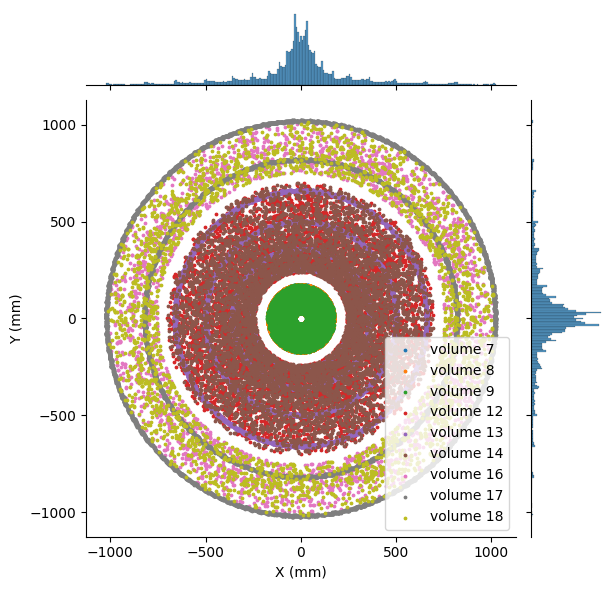

In [73]:
'''
Representación de los hits
'''
print(hits.head())

g = sns.jointplot(x=hits.x, y=hits.y, s=1, height=6)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

Dimensión dataset hits:   (120939, 7)
=========== Hits centrales ===========
       hit_id          x          y           z  volume_id  layer_id  \
16873   16874 -32.554401  -3.648710 -469.864990          8         2   
16874   16875 -33.153702  -1.934740 -423.516998          8         2   
16875   16876 -26.362400 -18.423700 -461.375000          8         2   
16876   16877 -12.034100 -29.649799 -464.428009          8         2   
16877   16878 -15.127200 -28.159300 -439.713989          8         2   

       module_id  
16873          1  
16874          1  
16875          2  
16876          3  
16877          3  
(29172, 7)
Tomamos solo un 24.1213% de los hits
Tengo un total de 1085 módulos
Tengo un total de 4 capas
Mis capas son: [2 4 6 8]
Data.shape() = (29172, 3)
Numero de hits en la primera capa: 8892
Data.shape() = (8892, 3)
Data.shape() = (1000, 3)
Número de pasos n =  1
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  2
Número de pasos n =  3
Número de pasos

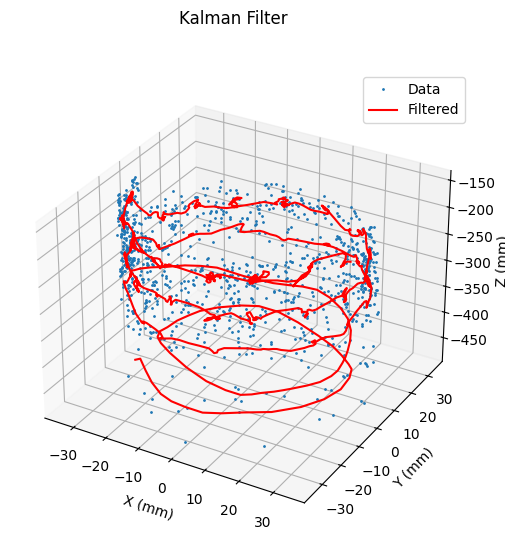

In [74]:
import importlib
import kalman_filter
importlib.reload(kalman_filter)
from kalman_filter import KalmanFilter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#print(hits.head())
print("Dimensión dataset hits:  ", hits.shape)
'''
Voy a querer elegir primero solo los hits centrales, es decir, los del volumen 8
'''

print("=========== Hits centrales ===========")
hits_centrales = hits[hits.volume_id == 8]
print(hits_centrales.head())
print(hits_centrales.shape)

print("Tomamos solo un {:.4f}% de los hits".format(hits_centrales.shape[0]/hits.shape[0]*100))

print(f"Tengo un total de {hits_centrales.module_id.nunique()} módulos")
print(f"Tengo un total de {hits_centrales.layer_id.nunique()} capas")
print(f"Mis capas son: {hits_centrales.layer_id.unique()}")

data = hits_centrales[['x', 'y', 'z']].values
#print(data)
print(f"Data.shape() = {data.shape}")

# Número de hits en la primera capa
print(f"Numero de hits en la primera capa: {hits_centrales[hits_centrales.layer_id == 2].shape[0]}")

# Tomemos solo los hits en la primera capa
data = hits_centrales[hits_centrales.layer_id == 2][['x', 'y', 'z']].values
print(f"Data.shape() = {data.shape}")

data = data[:1000]
print(f"Data.shape() = {data.shape}")

'''
plt.plot(data[:,0], 'o', label='X', markersize=.3)
plt.xlabel('Hit')
plt.ylabel('X (mm)')
plt.show()
'''
'''
Tengo que calcular x0 como trayectoria inicial entre un par de hits. 
'''

i = 1
hit_1 = hits_centrales[hits_centrales.module_id == i].iloc[0]
hit_2 = hits_centrales[hits_centrales.module_id == i+1].iloc[0]   

#hit_1 = hits_centrales.iloc[0]
#hit_2 = hits_centrales.iloc[1]

x1, y1, z1 = hit_1['x'], hit_1['y'], hit_1['z']
x2, y2, z2 = hit_2['x'], hit_2['y'], hit_2['z']

dt = 1.0

slope_x = (x2 - x1) / 1.0
slope_y = (y2 - y1) / 1.0
slope_z = (z2 - z1) / 1.0

#x0 = np.array([data[0,0], 0, data[0,1], 0, data[0,2], 0])
x0 = np.array([x1, slope_x, y1, slope_y, z1, slope_z]).reshape(-1, 1)
#print(x0)

dim_data = data.shape[1]

F = np.array([[1, dt, 0,  0,  0,  0],
              [0,  1,  0,  0,  0,  0],
              [0,  0,  1, dt,  0,  0],
              [0,  0,  0,  1,  0,  0],
              [0,  0,  0,  0,  1, dt],
              [0,  0,  0,  0,  0,  1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

C = np.eye(6) * 1e-3
Q = np.eye(6) * 0.1
R = np.eye(3) * 0.3

kf = KalmanFilter(C = C, F = F, 
                  H = H, Q = Q, R = R, x0 = x0)

trajectory = []
for i in range(int(len(data))):
    m = data[i]
    kf.predict()
    kf.update(m)
    kf.smoothing_RTS()
    smoothed_states, smoothed_positions = kf.smoothing_RTS()
    #trajectory.append(smoothed_positions)
    #trajectory.append(kf.x[[0, 2, 4]].flatten())


# Convertir a DataFrame, las posiciones x, y, z
#smoothed_df = pd.DataFrame(smoothed_positions[:, :, 0], columns=["x", "y", "z"])

# Eliminar la dimensión extra (dimensión de tamaño 1)
smoothed_positions = smoothed_positions.squeeze(axis=-1)
smoothed_df = pd.DataFrame(smoothed_positions, columns=["x", "y", "z"])


#with open('smoothed_df.txt', 'w') as f:
#    f.write(smoothed_df.to_string())

trajectory = smoothed_states
print(f"trajectory.shape = {trajectory.shape}")

print("\n=========== Smoothed_df ===========")
print(smoothed_df.head())


fig = plt.figure(figsize=(6, 6))
fig.suptitle('Kalman Filter')

ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0], data[:,1], data[:,2], 'o', label='Data', markersize=1)
ax.plot(trajectory[:,0], trajectory[:,2], trajectory[:,4], label='Filtered', color='red')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.legend()
plt.show()

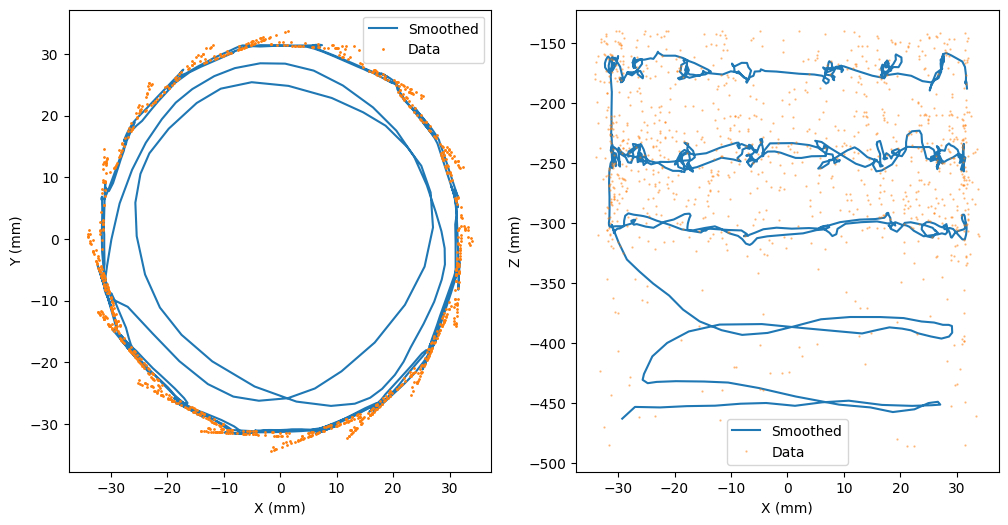

In [75]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(smoothed_df['x'], smoothed_df['y'], '-', label='Smoothed', markersize=.6)
plt.plot(data[:,0], data[:,1], 'o', label='Data', markersize=1)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smoothed_df['x'], smoothed_df['z'], '-', label='Smoothed', markersize=.6)
plt.plot(data[:,0], data[:,2], 'o', label='Data', markersize=.6, alpha=0.5)
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.legend()

plt.show()

1. Seleccionar pares de hits prometedores. 50 pares de hits entre capas adyacentes.

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         r      phi     theta  
0  -0.203492 -1      8  0.079048  2.32629  2.969372  
1   2.010060  1     11  0.079048  2.32629  2.969372  
2   0.683881 -1      0  0.079048  2.32629  2.969372  
3   0.991616  1     12  0.079048  2.32629  2.969372  
4 -39.824902  1      3  0.079048  2.32629  2.969372  


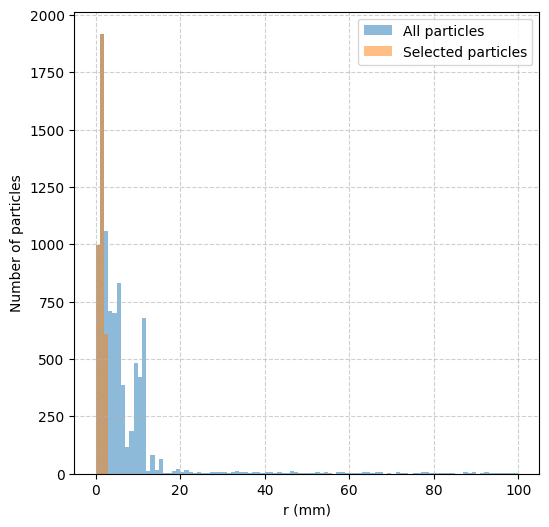

    hit_id          x         y       z  volume_id  layer_id  module_id
1        2 -55.336102  0.635342 -1502.5          7         2          1
9       10 -90.292900 -3.269370 -1502.5          7         2          1
10      11 -59.182999 -0.670508 -1502.5          7         2          1
12      13 -72.533997  2.642190 -1502.5          7         2          1
14      15 -63.436501 -3.262220 -1502.5          7         2          1
Los datos que tomo son un 29.4380% de los datos originales


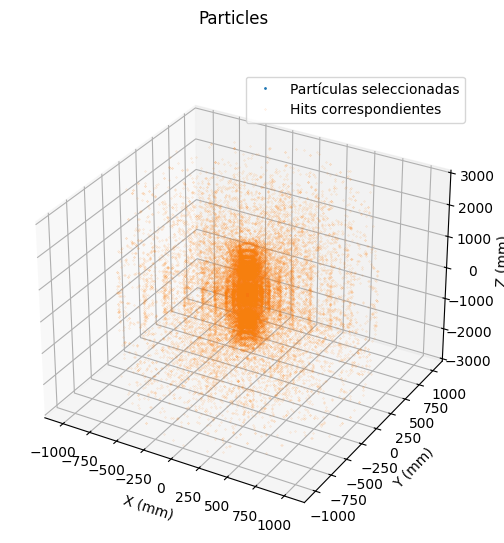

In [76]:
def distance(particle):
    ''' Distancia en mm de la partícula al origen'''
    return np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)

particles['r'] = distance(particles)
particles['phi'] = np.arctan2(particles.vy, particles.vx)
particles['theta'] = np.arccos(particles.vz / particles.r)

print(particles.head())

# Voy a coger solo las partículas con r < 2.6
particles_all = particles
particles = particles[particles.r < 2.6]

# Con ese radio, voy a coger solo las partículas con z entre -25 y 25 mm
particles = particles[(particles.vz > -25) & (particles.vz < 25)]

# Histograma normalizado a 1 de la variable r
plt.figure(figsize=(6, 6))
plt.hist(particles_all.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='All particles')
plt.hist(particles.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='Selected particles')
plt.legend()
plt.xlabel('r (mm)')    
plt.ylabel('Number of particles')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

# Del truth cojo solo las partículas que están en particles
truth = truth[truth.particle_id.isin(particles.particle_id)]

# Cojo ahora los hits_id que están en truth
hits_all = hits
hits = hits[hits.hit_id.isin(truth.hit_id)]
print(hits.head())

print("Los datos que tomo son un {:.4f}% de los datos originales".format(hits.shape[0]/hits_all.shape[0]*100))


# Represento el dataset de particles en 3D
fig = plt.figure(figsize=(6, 6))
plt.suptitle('Particles')
ax = fig.add_subplot(111, projection='3d')
ax.plot(particles.vx, particles.vy, particles.vz, 'o', markersize=1, label = 'Partículas seleccionadas')
#ax.plot(particles_all.vx, particles_all.vy, particles_all.vz, 'x', alpha  = .6, markersize = .6, label = 'Todas las partículas')
ax.plot(hits.x, hits.y, hits.z, 'o', markersize=.2, alpha= .4, label = 'Hits correspondientes')
ax.legend(loc = 'best')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.show()


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from kalman_filter import KalmanFilter

def distance(hit1, hit2):
    ''' Distancia entre dos hits '''
    dist = np.linalg.norm(hit1 - hit2)
    vector = hit2 - hit1
    return dist, vector

def cos_angle(v1, v2):
    ''' Calcula el coseno del ángulo entre dos vectores '''
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Tomamos solo los hits centrales del volumen 7
hits_centrales = hits[hits.volume_id == 7]

# Defino la posición del vértice
vertex = np.array([0, 0, 0])

hits_centrales = hits_centrales.copy()
hits_centrales['r'] = np.sqrt(hits_centrales.x**2 + hits_centrales.y**2 + hits_centrales.z**2)

hits_centrales_np = hits_centrales[['x', 'y', 'z']].values

# Reducimos la cantidad de hits a un porcentaje del total para acelerar el proceso
def reduce_hits(hits, fraction=0.2):
    '''Muestreo aleatorio de un porcentaje de hits'''
    return hits.sample(frac=fraction, random_state=42)

# Reducir el tamaño de los hits para las capas 2 y 4 (% de los hits)
hits_1 = reduce_hits(hits_centrales[hits_centrales.layer_id == 2])
hits_2 = reduce_hits(hits_centrales[hits_centrales.layer_id == 4])

hits_1_np = hits_1[['x', 'y', 'z']].values
hits_2_np = hits_2[['x', 'y', 'z']].values

hits_3 = hits_centrales[hits_centrales.layer_id == 6]
hits_4 = hits_centrales[hits_centrales.layer_id == 8]

hits_3_np = hits_3[['x', 'y', 'z']].values
hits_4_np = hits_4[['x', 'y', 'z']].values

# Inicializar variables
distances = []
vectors = []
all_tracks = []

# Inicializar las listas para almacenar las trayectorias suavizadas
tracks_layer_4 = []
tracks_layer_6 = []
tracks_layer_8 = []

tracks = []
# Propagación y filtro de Kalman
for i in tqdm(range(len(hits_1)), desc="Calculando distancias con vertex constraint"):
    hit1_pos = hits_1.iloc[i][['x', 'y', 'z']].values
    v1 = hit1_pos - vertex
    r1 = np.linalg.norm(hit1_pos)

    hits2_considered = 0  # Contador de hits considerados para cada hit1

    for j in range(len(hits_2)):    
        hit2_pos = hits_2.iloc[j][['x', 'y', 'z']].values
        v2 = hit2_pos - hit1_pos
        r2 = np.linalg.norm(hit2_pos)

        cos_value = cos_angle(v1, v2)  # Calculamos el coseno del ángulo

        if cos_value < -0.99:  # Si están alineados, consideramos este par
            hits2_considered += 1  # Incrementamos el contador de hits considerados
            
            # Mostrar cada 100 hits
            if hits2_considered % 100 == 0:
                print(f"cos_angle: {cos_value:.3f}")
                print(f"Hits capa 2 considerados: {hits2_considered} de {len(hits_2)}")

            dist, vector = distance(hit1_pos, hit2_pos)  # Calculamos la distancia y el vector de diferencia
            distances.append([i, j, dist])
            vectors.append(vector)

            # Establecer el estado inicial para el filtro de Kalman
            x1, y1, z1 = hit1_pos
            x2, y2, z2 = hit2_pos
            dt = 1.0  # Tiempo entre mediciones (puedes ajustarlo según corresponda)
            slope_x = (x2 - x1) / dt
            slope_y = (y2 - y1) / dt
            slope_z = (z2 - z1) / dt

            x0 = np.array([vector[0], slope_x, vector[1], slope_y, vector[2], slope_z])

            # Crear el filtro de Kalman
            kf = KalmanFilter(C=C, F=F, H=H, Q=Q, R=R, x0=x0)

            # ================== Capa 4 ==================
            kf.predict()  # Predicción inicial
            kf.update(hit2_pos)  # Actualización con hit de la capa 4
            smoothed_states_4, smoothed_positions_4 = kf.smoothing_RTS()  # Suavizado
            tracks_layer_4.append(smoothed_positions_4.reshape(-1, 3))  # Cambiar la forma aquí para eliminar la dimensión extra
            tracks.append(smoothed_positions_4.reshape(-1,3))

            # ================== Capa 6 ==================
            kf.predict()  # Predicción de la capa 4 a la 6
            pred_pos = kf.x[[0, 2, 4]].flatten()  # Predicción de posición (x, y, z)
            distances_layer6 = np.linalg.norm(hits_3_np - pred_pos, axis=1)
            best_hit6 = hits_3_np[np.argmin(distances_layer6)]  # Hit más cercano a la predicción
            kf.update(best_hit6)  # Actualización con el mejor hit
            smoothed_states_6, smoothed_positions_6 = kf.smoothing_RTS()  # Suavizado
            tracks_layer_6.append(smoothed_positions_6.reshape(-1, 3))  # Cambiar la forma aquí también
            tracks.append(smoothed_positions_6.reshape(-1,3))
            
            # ================== Capa 8 ==================
            kf.predict()  # Predicción de la capa 6 a la 8
            pred_pos = kf.x[[0, 2, 4]].flatten()
            distances_layer8 = np.linalg.norm(hits_4_np - pred_pos, axis=1)
            best_hit8 = hits_4_np[np.argmin(distances_layer8)]  # Hit más cercano a la predicción
            kf.update(best_hit8)  # Actualización con el mejor hit
            smoothed_states_8, smoothed_positions_8 = kf.smoothing_RTS()  # Suavizado
            tracks_layer_8.append(smoothed_positions_8.reshape(-1, 3))  # Cambiar la forma aquí también
            tracks.append(smoothed_positions_8.reshape(-1,3))
            
# Convertir las listas a arreglos numpy de 2D para cada capa
tracks_layer_4 = np.concatenate(tracks_layer_4, axis=0)  # Concatenar sobre la dimensión de las filas
tracks_layer_6 = np.concatenate(tracks_layer_6, axis=0)
tracks_layer_8 = np.concatenate(tracks_layer_8, axis=0)

# Verifica las nuevas formas
print(f"Tracks Layer 4 shape: {tracks_layer_4.shape}")
print(f"Tracks Layer 6 shape: {tracks_layer_6.shape}")
print(f"Tracks Layer 8 shape: {tracks_layer_8.shape}")

tracks = np.array(tracks)

# Graficar las trayectorias de las tres capas en el espacio 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Capa 4
ax.plot(tracks[:, 0], tracks[:, 1], tracks[:, 2], label="Layer 4", color='b')

# Capa 6
#ax.plot(tracks_layer_6[:, 0], tracks_layer_6[:, 1], tracks_layer_6[:, 2], label="Layer 6", color='g')

# Capa 8
#ax.plot(tracks_layer_8[:, 0], tracks_layer_8[:, 1], tracks_layer_8[:, 2], label="Layer 8", color='r')

# Etiquetas
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Título y leyenda
ax.set_title('Trayectorias por capa')
ax.legend()

# Mostrar la gráfica
plt.show()


Calculando distancias con vertex constraint:   4%|▍         | 4/92 [00:00<00:05, 17.02it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:   9%|▊         | 8/92 [00:00<00:04, 18.48it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  11%|█         | 10/92 [00:00<00:04, 18.64it/s]

Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de p

Calculando distancias con vertex constraint:  16%|█▋        | 15/92 [00:00<00:04, 18.33it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  18%|█▊        | 17/92 [00:00<00:04, 18.32it/s]

Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de p

Calculando distancias con vertex constraint:  24%|██▍       | 22/92 [00:01<00:03, 18.84it/s]

Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de p

Calculando distancias con vertex constraint:  28%|██▊       | 26/92 [00:01<00:04, 16.35it/s]

Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de p

Calculando distancias con vertex constraint:  30%|███       | 28/92 [00:01<00:03, 16.57it/s]

Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3


Calculando distancias con vertex constraint:  36%|███▌      | 33/92 [00:01<00:03, 17.42it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3


Calculando distancias con vertex constraint:  40%|████      | 37/92 [00:02<00:03, 18.01it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  45%|████▍     | 41/92 [00:02<00:02, 18.61it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  49%|████▉     | 45/92 [00:02<00:02, 18.33it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  53%|█████▎    | 49/92 [00:02<00:02, 17.93it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  55%|█████▌    | 51/92 [00:02<00:02, 18.19it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  60%|█████▉    | 55/92 [00:03<00:02, 17.38it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  65%|██████▌   | 60/92 [00:03<00:01, 18.26it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  70%|██████▉   | 64/92 [00:03<00:01, 18.71it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  74%|███████▍  | 68/92 [00:03<00:01, 18.73it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  78%|███████▊  | 72/92 [00:03<00:01, 18.49it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  84%|████████▎ | 77/92 [00:04<00:00, 19.51it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3


Calculando distancias con vertex constraint:  86%|████████▌ | 79/92 [00:04<00:00, 17.17it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  90%|█████████ | 83/92 [00:04<00:00, 17.64it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint:  95%|█████████▍| 87/92 [00:04<00:00, 18.05it/s]

Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de p

Calculando distancias con vertex constraint:  97%|█████████▋| 89/92 [00:04<00:00, 17.59it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de p

Calculando distancias con vertex constraint: 100%|██████████| 92/92 [00:05<00:00, 18.13it/s]

Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Número de pasos n =  1
Número de pasos n =  2
Número de pasos n =  3
Tracks Layer 4 shape: (449, 3)
Tracks Layer 6 shape: (898, 3)
Tracks Layer 8 shape: (1347, 3)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1347,) + inhomogeneous part.